# EDP : Analyse mathématique et principes de la méthode des éléments finis

### Ourkia Abdelhakim, Sarhane Abdelmouhaimen

## Position de Probléme

Soit $\Omega=] 0,1[\times] 0,1\left[\subset \mathbb{R}^2\right.$ et $\partial \Omega$ sa frontière partitionnée en deux sous-ensembles $\partial \Omega_n \cup \partial \Omega_d=\partial \Omega$. Etant donné $f \in L^2(\Omega), u_d \in H^1(\Omega)$ et $g \in L^2\left(\partial \Omega_n\right)$, le problème de Laplace revient à déterminer $u$ solution de:
$$
\left\{\begin{array}{rll}
-\Delta u(x, y) & =f(x, y) & \text { sur } \Omega, \\
u(x, y) & =u_d(x, y) & \text { sur } \partial \Omega_d, \\
\frac{\partial u(x, y)}{\partial n} & =g(x, y) & \text { sur } \partial \Omega_n,
\end{array}\right.
$$

Nous nous proposons de résoudre le problème en le discrétisant par la méthode des éléments
finis de Lagrange avec des élements finis de type P1 (approximation polynomiale du premier degré
sur un triangle ).

In [23]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [24]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [25]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [26]:
def calcule_M_Triangle(triangle , coordinates ):
    
    M =  np.zeros((3,3))
    # Récupération des coordonnées des sommets du triangle
    vertices = coordinates [triangle ,:]
    x = vertices[:,0]
    y = vertices[ :,1]
    # Calcul de 2 * l'aire du triangle 
    alpha = (x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0])
    
    for i in range(3):
        for j in range(3) :
                        # Calcul du gradient de la fonction de base associée au sommet i
                        grad_i = (1/alpha) * np.array([y[(i+1)%3]-y[(i+2)%3], x[(i+2)%3]-x[(i+1)%3]])
                        # Calcul du gradient de la fonction de base associée au sommet j
                        grad_j = (1/alpha) * np.array([y[(j+1)%3]-y[(j+2)%3], x[(j+2)%3]-x[(j+1)%3]])
                        
                        M[i,j] = (alpha/2) * (np.transpose(grad_i)@(grad_j))
    return M ,alpha

        
            
def assembling_triangle(coordinates, elements3, dirichlet,ud,f):

    # Nombre total de triangles
    N_T = elements3.shape[0]
    # Nombre total de sommets 
    n = coordinates.shape[0]

    # Initialisation de la matrice b et de la matrice A à zéro
    b= np.zeros((n,1))
    A = np.zeros((n,n))
    # Initialisation du vecteur U pour stocker les valeurs des conditions aux limites de Dirichlet
    U = np.zeros((n,1))

    
    for sommet in dirichlet :
          # Récupération des coordonnées du sommet
          vertices = coordinates[sommet][0]
           # Calcul de la valeur de la condition aux limites de Dirichlet
          U[sommet] = ud(vertices[0] , vertices[1])
    
    # Assemblage de la matrice globale A et du vecteur b
    for p in range(N_T) :
           # Récupération des sommets du triangle actuel
          triangle = elements3[p,:]
          # Calcul des coordonnées du centre de gravité du triangle
          vertices = coordinates[triangle]
          xg, yg = np.sum(vertices/3, axis=0)
          # Calcul de la matrice de raideur 
          M_T , alpha = calcule_M_Triangle(triangle, coordinates)
          # Ajout de la contribution du triangle à la matrice globale A
          A[triangle[:,None] , triangle] += M_T
          # Ajout de la contribution du triangle au vecteur b
          b[triangle] += np.ones((3,1)) *(alpha/6)*f(xg,yg) 
    b = b - A@U
    # Calculer l interieur de omega
    interieur= np.array([i for i in range(len(coordinates)) if i not in dirichlet])
    
    # Résolution du système linéaire
    A = A[interieur][:,interieur]
    b = b[interieur]
    sol = (np.linalg.inv(A)).dot(b)
    U[interieur] = sol 
    return A,b,U



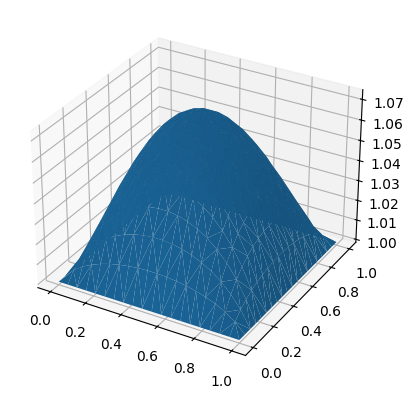

In [27]:
# Defines the funtion for the second member
def f(x,y):
    return 1

# Defines the function for the Dirichlet conditions
def u_d(x,y):
    return 1

coordinates, elements3, dirichlet, neumann = maillage(20)
A,b, sol = assembling_triangle(coordinates, elements3, dirichlet,u_d,f)





sol = sol.flatten()
show(coordinates, sol)

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [28]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

## Matrice de raideur pour les éléments de type quadrangle
$$
\begin{aligned}
\nabla \varphi_1 &= \begin{pmatrix} \frac{\partial \phi_1}{\partial \xi} \\ \frac{\partial \phi_1}{\partial \zeta} \end{pmatrix} = \begin{pmatrix} -1 + \zeta \\ -1 + \xi \end{pmatrix} \\
\nabla \varphi_2 &= \begin{pmatrix} \frac{\partial \phi_2}{\partial \xi} \\ \frac{\partial \phi_2}{\partial \zeta} \end{pmatrix} = \begin{pmatrix} 1 - \zeta \\ -\xi \end{pmatrix} \\
\nabla \varphi_3 &= \begin{pmatrix} \frac{\partial \phi_3}{\partial \xi} \\ \frac{\partial \phi_3}{\partial \zeta} \end{pmatrix} = \begin{pmatrix} \zeta \\ \xi \end{pmatrix} \\
\nabla \varphi_4 &= \begin{pmatrix} \frac{\partial \phi_4}{\partial \xi} \\ \frac{\partial \phi_4}{\partial \zeta} \end{pmatrix} = \begin{pmatrix} -\zeta \\ 1 - \xi \end{pmatrix}
\end{aligned}
$$

Pour les éléments de type quadrangle, la matrice de raideur $M$ peut être calculée comme suit:
$$
M_{i j}=\int_0^1 \int_0^1 \nabla \varphi_i^T\left(J_\phi^T J_\phi\right)^{-1} \nabla \varphi_j^T\left|J_\phi\right| d \epsilon d \mu
$$
avec $J_\phi$ la matrice jacobienne de $\phi$. Comme $J_\phi^T J_\phi$ est symétrique, son inverse l'est aussi, ce qui donne la matrice suivante:
$$
\left(J_\phi^T J_\phi\right)^{-1}=\left(\begin{array}{ll}
a & b \\
b & c
\end{array}\right)
$$

en utilisant le fait que la matrice $M$ est symétrique, il nous suffit de calculer les termes de la partie triangulaire supérieure et les termes diagonaux :
$$
\begin{aligned}
& M_{11}=\left|J_\phi\right|\left(\frac{a}{3}+\frac{c}{3}+\frac{b}{2}\right) \\
& M_{22}=\left|J_\phi\right|\left(\frac{a}{3}+\frac{c}{3}-\frac{b}{2}\right) \\
& M_{33}=\left|J_\phi\right|\left(\frac{a}{3}+\frac{b}{2}+\frac{c}{3}\right) \\
& M_{44}=\left|J_\phi\right|\left(\frac{a}{3}-\frac{b}{2}+\frac{c}{3}\right) \\
& M_{12}=\left|J_\phi\right|\left(\frac{c}{6}-\frac{a}{3}\right) \\
& M_{13}=\left|J_\phi\right|\left(-\frac{a}{6}-\frac{c}{6}-\frac{b}{2}\right)\\
& M_{14}=\left|J_\phi\right|\left(\frac{a}{6}-\frac{c}{3}\right) \\
& M_{23}=\left|J_\phi\right|\left(\frac{a}{6}-\frac{c}{3}\right) \\
& M_{24}=\left|J_\phi\right|\left(\frac{b}{2}-\frac{a}{6}-\frac{c}{6}\right) \\
& M_{34}=\left|J_\phi\right|\left(\frac{c}{6}-\frac{a}{3}\right)
\end{aligned}
$$

Ce qui donne finalement :
$$
M=\frac{\left|J_\phi\right|}{6}\left(\begin{array}{cccc}
2 a+3 b+2 c & -2 a+c & -a-3 b-c & a-2 c \\
-2 a+c & 2 a-3 b+2 c & a-2 c & -a+3 b-c \\
-a-3 b-c & a-2 c & 2 a+3 b+2 c & -2 a+c \\
a-2 c & -a+3 b-c & -2 a+c & 2 a-3 b+2 c
\end{array}\right)
$$

**Calcul de terme de Neumann**

La méthode des points milieux approxime l'intégrale d'une fonction sur un intervalle en évaluant la fonction aux points milieux de l'intervalle et en multipliant chaque valeur par la longueur de l'intervalle. Dans notre cas, nous appliquons cette méthode à chaque segment de la frontière $\partial \Omega​$.



1. Divisez la frontière  $\partial \Omega​$​ en segments.
2. Pour chaque segment de la frontière, calculez le point milieu et évaluez la fonction $g$ à ce point.
3. Multipliez la valeur de $g$ au point milieu par la longueur du segment.

Voici une formule plus:

$$\int_{\partial\Omega_n} g \eta_i \, dx \approx \sum_{j=1}^{m} g(m_j) \cdot \ell_j$$

Où $m_j$​ est le point milieu du j-ème segment de la frontière $\partial \Omega​$​ avec une longueur $l_j$​, et $m$ est le nombre total de segments sur la frontière $\partial \Omega​$

In [29]:
def calcule_M_Quadrangle(quadrangle , coordinates ):
    # Récupération des coordonnées des sommets du quadrangle
    vertices = coordinates[quadrangle ,:]
    x = vertices[:,0]
    y = vertices[ :,1]
    
    J = np.array([[x[1]-x[0], x[3]-x[0]], [y[1]-y[0], y[3]-y[0]]])
    C = np.linalg.inv (J.T @ J)

    a = C[0,0]
    b = C[0,1]
    c = C[1,1]

    alpha = np.linalg.det(J)
    # Calcul de la matrice de raideur M
    M = (alpha/6) * np.array([
        [2*a + 3*b + 2*c, -2*a + c, -a - 3*b - c, a - 2*c],
        [-2*a + c, 2*a - 3*b + 2*c, a - 2*c, -a + 3*b - c],
        [-a - 3*b - c, a - 2*c, 2*a + 3*b + 2*c, -2*a + c],
        [a - 2*c, -a + 3*b - c, -2*a + c, 2*a - 3*b + 2*c]
    ])


    return M ,alpha

In [30]:
def assembling_mixte(coordinates, elements4, elements3, dirichlet,neumann, ud,f,g):
    # Nombre total de triangles et de quadrangles
    N_T = elements3.shape[0]
    N_Q = elements4.shape[0]
    # Nombre total de sommets 
    n = coordinates.shape[0]
    # Initialisation de la matrice b et de la matrice A à zéro
    b= np.zeros((n,1))
    A = np.zeros((n,n))
    # Initialisation du vecteur U pour stocker les valeurs des conditions aux limites de Dirichlet
    U = np.zeros((n,1))
    # Prise en compte des conditions aux frontières
    for sommet in dirichlet :
         
          vertices = coordinates[sommet]
          
          U[sommet] = ud(vertices[0] , vertices[1])
    
    # Assemblage des contributions des triangles
    for p in range(N_T) :
      # Récupération des sommets du triangle actuel
      triangle = elements3[p,:]
      # Calcul des coordonnées du centre de gravité du triangle
      vertices = coordinates[triangle]
      xg, yg = np.sum(vertices/3, axis=0)
       # Ajout de la contribution du triangle à la matrice globale A
      M_T , alpha = calcule_M_Triangle(triangle, coordinates)
      A[triangle[:,None] , triangle] += M_T
      # Ajout de la contribution du triangle au vecteur b
      b[triangle] += np.ones((3,1)) *(alpha/6)*f(xg,yg) 

    # Assemblage des contributions des quadrangles
    for p in range(N_Q) :
          # Récupération des sommets du quadrangle actuel
          quadrangle = elements4[p,:]
          # Calcul des coordonnées du centre de gravité du quadrangle
          vertices = coordinates[quadrangle]
          xg, yg = np.sum(vertices/4, axis=0)
          # Calcul de la matrice de raideur
          M_T , alpha = calcule_M_Quadrangle(quadrangle, coordinates)
          # Ajout de la contribution du quadrangle à la matrice globale A
          A[quadrangle[:,None] , quadrangle] += M_T
          # Ajout de la contribution du quadrangle au vecteur b
          b[quadrangle] += np.ones((4,1)) *(alpha/4)*f(xg,yg) 

    # Calcul de l'integral par la methode du point milieu
    # Traitement des conditions de Neumann
    for cond in neumann :
         i,j = cond[0],cond[1]
         # Récupération des coordonnées des sommets
         v1 = coordinates[i]
         v2 = coordinates[j]
         # Calcul du point milieu du segment
         vc = (v1+v2)/2
         # Calcul de la longueur du segment
         d = np.linalg.norm(v2 - v1)
         # Ajout de la contribution de la condition de Neumann au vecteur b
         b[i] += d* g(vc[0],vc[1])
         b[j] += d * g(vc[0],vc[1])
    b = b - A@U
    #calcul de l interieur de omega
    interieur= np.array([i for i in range(len(coordinates)) if i not in dirichlet])
    
    # Résolution du système linéaire
    A = A[interieur][:,interieur]
    b = b[interieur]
    sol = (np.linalg.inv(A)).dot(b)
    U[interieur] = sol 
    return A,b,U

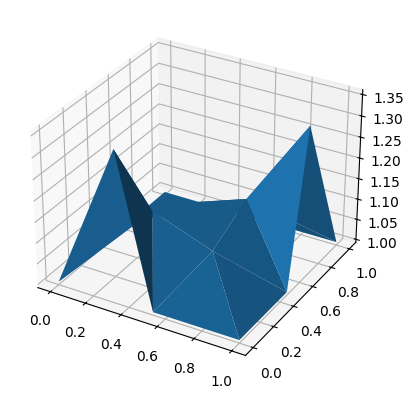

In [31]:
def f(x,y) :
    return 1

def g(x,y) :
    return 1

def u_d(x,y):
    return 1


A,b, sol = assembling_mixte(ccs, e4,e3, dds,nns,u_d,f,g)


sol = sol.flatten()

show(ccs, sol)

**Compléments  :  un nouveau terme dans l'EDP**

# Compléments : introduction d’un nouveau terme dans l’EDP


$\left\{\begin{aligned}-\Delta u(x, y)+c_0 u(x, y) & =f(x, y) & & \text { sur } \Omega, \\ u(x, y) & =0 & & \text { sur } \partial \Omega,\end{aligned}\right.$

avec $c_0>0$ une constante.

## La formulation variationnelle

Le problème s'écrira comme suit:
On cherche $u$ dans $H^2(\Omega) \cap H_0^1(\Omega)$ solution de
$$
\left\{\begin{array}{l}
-\Delta u(x, y)+c_0 u(x, y)=f(x, y) \quad \text { sur } L^2(\Omega) \\
\gamma_0(u(x, y))=0 \quad \text { sur } \partial \Omega
\end{array}\right.
$$

Soit $v$ $\in$ $L^2(\Omega)$.

$-\Delta u v, f v$ sont intégrables sur $\Omega$.
Alors:
$$
\int_{\Omega} - \Delta u(x, y) v d x+c_0 \int_{\Omega} u(x, y) v d x=\int_{\Omega} f(x, y) v d x
$$

$u$ $\in$ $H^2(\Omega)$ donc $\nabla u$ $\in$ $H^1(\Omega)$, et $\forall v \in$ $H^1(\Omega)$

La formule de Green: $$\int_{\Omega} \nabla u \nabla v d x-\int_{\partial \Omega} \gamma_1(u) \gamma_0(v) d x+c_0 \int_{\Omega} u(x, y) v d x=\int_{\Omega} f(x, y) v d x$$


**Le problème mis sous forme variationnelle :**

On cherche $u$ appartenant à $H^1(\Omega)$ parce qu'on veut les dérivées partielles faibles d'ordre 1 uniquement, conformément aux conditions aux limites de Dirichlet homogène ( $u = 0$ ) on suppose $\gamma_0(u) = 0$, or $\text{ker} \, \gamma_0 = H^1_0(\Omega)$, donc on cherche  une solution dans $H_0^1(\Omega)$.

Ainsi, le problème est formulé comme suit en prenant 
$v \in H_0^1(\Omega)$ tel que $\gamma_0(v)=0$
$$
\int_{\Omega} \nabla u \nabla v d x+c_0 \int_{\Omega} u(x, y) v d x=\int_{\Omega} f(x, y) v d x
$$



<b>L'unicité de la solution:</b>

Le problème peut être formulé comme suit : trouver $u$ tel que $a(u, v)=l(v)$, avec $u, v \in H_0^1(\Omega)$, où :
$$
\begin{aligned}
& a(u, v)=\int_{\Omega} \nabla u \cdot \nabla v d x+c_0 \int_{\Omega} u v d x \\
& l(v)=\int_{\Omega} f v d x
\end{aligned}
$$

Tout d'abord, montrons que $(u, v) \mapsto a(u, v)$ est une forme bilinéaire continue et coercitive.

La forme $a(u, v)$ est clairement bilinéaire par linéarité de l'intégrale et bilinéarité des applications sous l'intégrale. En effet,
$$
a(u, v)=\int_{\Omega} \nabla u \cdot \nabla v d x+c_0 \int_{\Omega} u v d x=\langle\nabla u, \nabla v\rangle_{1, \Omega}+c_0\langle u, v\rangle_{L^2(\Omega)}
$$

En utilisant linégalité de Cauchy-Schwarz et comme $c_0>0$, on obtient:
$$
|a(u, v)| \leq|u|_{1, \Omega}|v|_{1, \Omega}+c_0\|u\|_{L^2(\Omega)}\|v\|_{L^2(\Omega)}
$$

L'inégalité de Poincaré pour un ouvert $\Omega$ assure l'existence d'une constante $C$ telle que $\|v\|_{L^2(\Omega)} \leq C^2|v|_{1, \Omega}$. Ainsi,
$$
|a(u, v)| \leq\left(1+c_0 C^2\right)|u|_{1, \Omega}|v|_{1, \Omega}
$$

Cela démontre la continuité de $(u, v) \mapsto a(u, v)$. Ensuite, pour la coercivité, considérons $|a(v, v)|:$
$$
|a(v, v)|=|v|_{1, \Omega}^2+c_0\|v\|_{L^2(\Omega)}^2
$$

Ainsi,
$$
|a(v, v)| \geq|v|_{1, \Omega}^2
$$

Cela prouve la coercivité de $a(u, v)$.


<b>Ensuite, pour montrer que $v \mapsto l(v)$ est une forme linéaire continue</b>, remarquons d'abord que la linéarité de l'intégrale assure la linéarité de $v \mapsto$ $l(v)$. Ensuite, comme $|l(v)|=\langle f, v\rangle_{L^2(\Omega)}$, l'inégalité de Cauchy-Schwarz nous donne:
$$
\mid l(v)\mid  \leq\|f\|_{L^2(\Omega)}\|v\|_{L^2(\Omega)}
$$

En utilisant l'inégalité de Poincaré, nous obtenons $\|v\|_{L^2(\Omega)} \leq C|v|_{1, \Omega}$, d'où :
$$
\left.l(v)|\leq L| v\right|_{1, \Omega}
$$
avec $L=C\|f\|_{L^2(\Omega)}$. Cela prouve que $v \mapsto l(v)$ est une forme linéaire continue.

D'après le théorème de Lax-Milgram, nous pouvons conclure qu'il existe une unique solution $u \in H_0^1(\Omega)$ pour $a(u, v)=l(v)$, $\forall v \in H_0^1(\Omega)$.

## Résultat de la forme variationnelle discrète :

Soit $n=\operatorname{dim} V_h(<+\infty)\\$
Soit $\left(\eta_i\right)_{i \in\left[1, n\right]} \in V_h^{n}$ une base de $V_h$.

$\forall v_h \in V_h  \exists!\left(u_i\right) \in \mathbb{R}^{n} \quad t_q u_n=\sum_{i=1}^{n} u_i \eta_i$
$$
\begin{aligned}
\text { Une solution de }\left(P_{F V H}\right) & \Leftrightarrow \forall v_h \in V_h, a\left(u_n, v_h\right)=l\left(v_h\right) \\
& \Leftrightarrow \forall i \in \llbracket 1, n \rrbracket a\left(u_n, \eta_i\right)=l\left(\eta_i\right) \\
& \Leftrightarrow \forall i \in\llbracket 1, n \rrbracket a\left(\sum_j^n u_j \eta_j, \eta_i\right)=l\left(\eta_i\right) \\
& \Leftrightarrow \forall i \in \llbracket 1, n \rrbracket \sum_{j=1}^{n} a\left(\eta_j, \eta_i\right) u_j=l\left(\eta_i\right) . \\
& \Leftrightarrow A x=b
\end{aligned}
$$
avec $A \in \mathcal{M}_{n}(\mathbb{R}) $ tel que $\forall(i, j) \in\llbracket 1, n \rrbracket^2 \quad a_{i j}=a\left(\eta_j, \eta_i\right)$
$$
\begin{aligned}
& b \in \mathbb{R}^{n} \quad \forall i \in\llbracket 1, n \rrbracket \quad b_i=l\left(\eta_i\right) \\
& x=\left(u_i\right)_{i \in \llbracket 1, n \rrbracket}
\end{aligned}
$$

**Existence et unicité de la solution**

Soit $x \in R^n$ un vecteur non nul, on a :
$$
x^T A x=\sum_{i, j=1}^n A_{i j} x_i x_j=\sum_{i, j=1}^n a\left(\eta_i, \eta_j\right) x_i x_j=a\left(\sum_{j=1}^n x_j \eta_j, \sum_{i=1}^n x_i \eta_i\right)
$$
Or a est coercive, donc $x^T A x=a\left(x^*, x^*\right) \geq\left|x^*\right|_{1, \Omega}^2$

Si $\left|x^*\right|_{1, \Omega}^2=0$ alors $x^*=0$ alors $\forall i \in[1, n]: x_i=0$ donc $x=0$.
Alors $x^T A x>0$ 

donc $A$ est définie positive et le système admet une unique solution.

##  la stratégie de l'élément de référence:

La méthode de l'élément de référence est utilisée pour calculer $\int_T c_0 \eta_i \eta_j d x d y$ en s'appuyant sur le triangle unité.

$
\text {On sait que : } \eta_j(x, y)=\varphi_j\left(\phi_T^{-1}(x, y)\right)$

En effectuant un changement de variable et en procédant aux calculs, nous avons démontré que pour tout $(i, j) \in[1: 3] \times[1: 3]:$

$$c_0 \int_T \eta_i(x, y) \eta_j(x, y) d x d y=c_0 \int_{T_u} \varphi_i(a, b) \varphi_j(a, b)\left|J_T\right| d a d b

=c_0 \int_0^1 \int_0^{1-b} \varphi_i(a, b) \varphi_j(a, b)\left|J_T\right| d a d b
$$

Ce qui nous donne:

$c_0 \int_T \eta_i(x, y) \eta_j(x, y) d x d y=\frac{c_0\left|J_T\right|}{12}$ 
si $i=j$,

et

$c_0 \int_T \eta_i(x, y) \eta_j(x, y) d x d y=\frac{c_0\left|J_T\right|}{24}$ si $i \neq j$.


In [32]:
def calcule_M_T_2(triangle , coordinates ,c0):
    # Initialisation de la matrice M à zéro
    M =  np.zeros((3,3))
    # Récupération des coordonnées des sommets du triangle
    vertices = coordinates [triangle ,:]
    x = vertices[:,0]
    y = vertices[ :,1]
    alpha = (x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0])
    aire = alpha/2
    
    for i in range(3):
        for j in range(3) :
                        # Calcul du gradient de la fonction de base associée au sommet i
                        grad_i = (1/alpha) * np.array([y[(i+1)%3]-y[(i+2)%3], x[(i+2)%3]-x[(i+1)%3]])
                        # Calcul du gradient de la fonction de base associée au sommet j
                        grad_j = (1/alpha) * np.array([y[(j+1)%3]-y[(j+2)%3], x[(j+2)%3]-x[(j+1)%3]])
                        # Calcul de l'élément de la matrice M correspondant à i et j
                        if i == j :
                              M[i,j] = (alpha/2) * (np.transpose(grad_i)@(grad_j)) + (c0 * alpha /12)
                        else:
                              M[i,j] = (alpha/2) * (np.transpose(grad_i)@(grad_j)) + (c0 * alpha /24)
                        

    return M ,alpha





#resoudre_formulation_variationnelle_discrete
def resoudre_formulation_variationnelle_discrete(coordinates, elements3, dirichlet,c0,f):
    # Nombre total de triangles
    N_T = elements3.shape[0]
    n = coordinates.shape[0]
    # Initialisation de la matrice b et de la matrice A à zéro
    b= np.zeros((n,1))
    A = np.zeros((n,n))

    U = np.zeros((n,1))


    # Assemblage de la matrice globale A et du vecteur b
    for p in range(N_T) :
          triangle = elements3[p,:]
          vertices = coordinates[triangle]
          xg, yg = np.sum(vertices/3, axis=0)
          M_T , alpha = calcule_M_T_2(triangle, coordinates,c0)
          A[triangle[:,None] , triangle] += M_T
          b[triangle] += np.ones((3,1)) *(alpha/6)*f(xg,yg) 
    
        
    interieur= np.array([i for i in range(len(coordinates)) if i not in dirichlet])
    
    # Résolution du système linéaire
    A = A[interieur][:,interieur]
    b = b[interieur]
    sol = (np.linalg.inv(A)).dot(b)
    U[interieur] = sol 
    return A,b,U


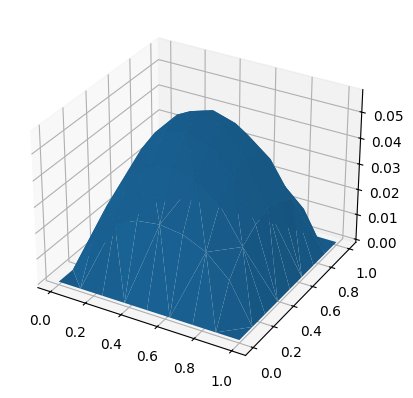

In [33]:
def f(x,y):
    return 1

# Defines the function for the Dirichlet conditions
def u_d(x,y):
    return 0
c0 = 5
coordinates, elements3, dirichlet, neumann = maillage(9)
A,b, sol = resoudre_formulation_variationnelle_discrete(coordinates, elements3, dirichlet,c0,f)


sol = sol.flatten()
show(coordinates, sol)